In [23]:
#https://docs.quantum.ibm.com/guides/build-noise-models
#https://docs.quantum.ibm.com/api/qiskit/0.37/aer_noise

In [24]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from scipy.optimize import curve_fit

In [25]:
#from qiskit import IBMQ
#IBMQ.save_account('8587d453fc4802634c0c9ed4bd7ffcb2bc35171cedc0026f964732de58e2f02d910530b93239b25afd0e1c39b8a18d448ab81b677a69b2b93de9655f49067214')

configrc.store_credentials:WARNING:2024-08-20 15:44:09,087: Credentials already present. Set overwrite=True to overwrite.


In [26]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit import IBMQ, Aer
# Build noise model from backend properties
provider = IBMQ.load_account()                     #Muss man nur einmal laufen lassen I think
backend = provider.get_backend('ibm_brisbane')         #ibm_kyiv, ibm_sherbrooke, ibm_brisbane, ibm_kyoto          Es gibt kein "ibm_vigo"!!!!!
noise_model = NoiseModel.from_backend(backend)
 
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
 
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

ibmqfactory.load_account:WARNING:2024-08-20 15:44:09,447: Credentials are already in use. The existing account in the session will be replaced.


In [27]:
def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    ##1 Initialization

    q0, q1 = qr
    # apply Hadamard on the auxiliary qubit
    qc.h(q0)
    # put the system qubit into the |1> state
    qc.x(q1)

    ##2 Apply control-U operator as many times as needed to get the least significant phase bit

    # we want to apply controlled-S 2^k times
    k = 0
    # calculate the angle of CPhase corresponding to 2^k applications of angle
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##3 Measure the auxiliary qubit in x-basis into the first classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    c0 = cr
    qc.measure(q0, c0)

    return qc


def iqpe(angle: float, steps: int, bits_list = []):
    if steps == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(1, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!!
    else:
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(steps, "c")
        q0, q1 = qr

        list = []
        for i in range(97, 97+steps):                               #hier die Liste mit dem Classical Register
            list.append("{:c}".format(i))
        list = cr
        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit
        if not bits_list:                                                                                           #"Normaler" QPE-Circuit
            qc.h(q0)
            # put the system qubit into the |1> state
            qc.x(q1)
            ##2 Apply control-U operator as many times as needed to get the least significant phase bit
            # we want to apply controlled-S 2^k times
            k = steps-1
            # calculate the angle of CPhase corresponding to 2^k applications of angle
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)
            ##3 Measure the auxiliary qubit in x-basis into the first classical bit
            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit                   
            qc.measure(q0, list[0])

            for i in range(1,steps):                                                                                                   
                qc.reset(q0)
                # apply Hadamard on the auxiiliary qubit
                qc.h(q0)

                ##2 Apply phase correction conditioned on the first classical bit

                for j in range(i):
                    with qc.if_test((list[j], 1)):
                        qc.p((-2*np.pi)/(2**(i-j+1)), q0)

                ##3 Apply control-U operator as many times as needed to get the next phase bit

                # we want to apply controlled-S 2^k times
                k = steps - i - 1
                # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
                cphase_angle = angle * 2**k
                # apply the controlled phase gate
                qc.cp(cphase_angle, q0, q1)

                ##4 Measure the auxiliary qubit in x-basis into the second classical bit

                # apply Hadamard to change to the X basis
                qc.h(q0)
                # measure the auxiliary qubit into the first classical bit
                qc.measure(q0, list[i])
            
            return qc

        else:
            qc.x(q1)
            for j in range(len(bits_list)):
                qc.reset(q0)
                if bits_list[j] == "1":
                    qc.x(q0)
                    qc.measure(q0, list[j])


        qc.reset(q0)
        # apply Hadamard on the auxiiliary qubit
        qc.h(q0)

        ##2 Apply phase correction conditioned on the first classical bit

        for j in range(steps-1):
            if bits_list[j] == "1":
                qc.p((-2*np.pi)/(2**(steps-j)), q0)
            # with qc.if_test((list[j], 1)):
            #     qc.p((-2*np.pi)/(2**(i-j+1)), q0)

        # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
        cphase_angle = angle
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)

        ##4 Measure the auxiliary qubit in x-basis into the second classical bit

        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit
        qc.measure(q0, list[steps-1])
        
        return qc
#Funktioniert

def iqpe_improved(angle: float, shots_per_it: list):                            #Länge der Liste + 1 gibt mir meine depth bzw. #Iterationen
    bits_list=[]
    if  len(shots_per_it) == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(1, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!!
    else:
        steps = len(shots_per_it) + 1
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(1, "c")
        q0, q1 = qr

        list = []
        list.append("c0")
        list = cr

        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit                                             
        qc.h(q0)
        # put the system qubit into the |1> state
        qc.x(q1)
        ##2 Apply control-U operator as many times as needed to get the least significant phase bit
        # we want to apply controlled-S 2^k times
        k = steps-1
        # calculate the angle of CPhase corresponding to 2^k applications of angle
        cphase_angle = angle * 2**k
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)
        ##3 Measure the auxiliary qubit in x-basis into the first classical bit
        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit                                    
        qc.measure(q0, list[0])                                                                                                     #Bis hier, nur step_1_circuit
        sim = AerSimulator()
        job = sim.run(qc, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates,shots=shots_per_it[0])
        result = job.result()
        counts = result.get_counts()
        max_val = max(counts.values())
        max_keys = []
        for key in counts:
            if counts[key] == max_val:
                max_keys.append(key)
        chosen_one = max_keys[0]
        bits_list.append(chosen_one)

        for i in range(1,steps-1):                                                                                                    #Ab hier, gehts weiter über die for schleife
            qr = QuantumRegister(2,"q")
            cr = ClassicalRegister(1, "c")
            q0, q1 = qr
            list = []
            list.append("c0")
            list = cr
            qc = QuantumCircuit(qr,cr)

            # if bits_list[i-1] == "1":
            #     qc.x(q0)

            # apply Hadamard on the auxiiliary qubit
            qc.h(q0)
            qc.x(q1)
            ##2 Apply phase correction conditioned on the first classical bit
            for j in range(i):
                if bits_list[j] == "1":
                    qc.p((-2*np.pi)/(2**(i-j+1)), q0)
            ##3 Apply control-U operator as many times as needed to get the next phase bit
            # we want to apply controlled-S 2^k times
            k = steps - i - 1
            # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)
            ##4 Measure the auxiliary qubit in x-basis into the second classical bit
            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit
            qc.measure(q0, list[0])
            sim = AerSimulator()
            job = sim.run(qc, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots_per_it[i])
            result = job.result()
            counts = result.get_counts()
            max_val = max(counts.values())
            max_keys = []
            for key in counts:
                if counts[key] == max_val:
                    max_keys.append(key)
            chosen_one = max_keys[0]
            bits_list.append(chosen_one)
        return iqpe(angle, steps , bits_list)

#Funktioniert
def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n
#Funktioniert

def mean(x: list, y: list):                 #bildet den Mittelwert unter den Shots einer Messung
    m = 0
    total = 0
    for i in range(len(x)):
        m += x[i]*y[i]
        total += y[i]
    m = m*(1/total)
    return m
#Funktioniert

def closest_bin(n: float, prec: int):           #Gibt einem den nächsten binären Nachbarn zu einem Float an bei gegebener Präzision/Depth
    closest = 10
    steps = 2**(-prec)
    bin_list = [i*steps for i in range(2**prec+1)]
    for i in bin_list:
        if np.abs(n - i) < np.abs(closest-n):
            closest = i
    return closest
#Funktioniert

def plot_closest_bin_per_depth(n: float, maxdepth: int):            #Plottet wie sich die binären Nachbarn bei einem Float ändern für unterschiedliche Präzision/Depth
    x = [i for i in range(maxdepth)]
    y_old = [closest_bin(n,i) for i in range(maxdepth)]
    y = [0]
    for i in range(len(x)-1):
        y.append(y_old[i+1]-y_old[i])
    
    invalid = []
    for i in range(len(x)):
        if y[i] == 0:
            invalid.append(x[i])
    invalid_y = [0 for i in invalid]
    fig, ax = plt.subplots(figsize=(12,6))
    plt.plot(x,y,"x",linestyle="dotted")
    plt.plot(invalid, invalid_y, "x", color = "red", label="No change of binary neighbour")
    plt.xlabel("Depth")
    plt.ylabel("Difference between current and previous binary neighbour")
    plt.title("Änderung der binären Nachbarn für versch. Präzisionen für die Zahl {}".format(n))
    plt.legend()
#Funktioniert

In [92]:
def measurement(angle: float, depth: int, num: float, shots_per_it = 0):                #Plottet eine Messung mit fixed Winkel, Depth und Shotzahl
    
    theta = 2*np.pi*angle
    if shots_per_it == 0:
        qc = iqpe(theta,depth)
    else:
        listt = [shots_per_it for i in range(depth-1)]
        qc = iqpe_improved(theta, listt)

    sim = AerSimulator()
    job = sim.run(qc, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=int(num))
    result = job.result()
    counts = result.get_counts()
    keys = counts.keys()
    values = counts.values()
    keys = [convert(i) for i in keys]
    values = [i for i in values]
    
    avg = mean(keys, values)
    diff = np.abs(avg-angle)
    print("Difference between Mean of Mesurement and Desired Value: ", diff)
    theory = 2**(-depth)
    print("Theoretical precision of QPE with the same depth: ", theory)
    print("Improvement by ", theory/diff)

    fig, ax1 = plt.subplots(figsize=(13,5))

    ax1 = plt.bar(keys, values, width = 2**(-depth-3), label="Measured")

    plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
    plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
    if shots_per_it == 0:
        plt.title("Iteration Cycles: {}, Input Angle: {}, Shots: {}".format(depth, angle, int(num)))
    else:
        plt.title("iQPE+: Iteration Cycles: {}, Input Angle: {}, {} Shots per Iteration, Final Shots: {}".format(depth, angle, shots_per_it, int(num)))
    plt.xlim(-0.1,1.1)

    plt.legend()

def plot_prec_over_its(angle: float, shots:int, maxdepth:int, shots_per_it = 0):          #Plottet Präzision in Abh. der Iterations für fixed Winkel/Shotzahl
    list_diff = []
    x = []
    if shots_per_it == 0:
        for i in range(1,maxdepth):
            depth = i
            theta = 2*np.pi*angle
            qc = iqpe(theta,depth)

            sim = AerSimulator()
            job = sim.run(qc, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=int(shots))
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            list_diff.append(diff)

            x.append(i)
    else:
        theta = 2*np.pi*angle
        for i in range(1,maxdepth):
            if i == 1:
                theta = 2*np.pi*angle
                qc = iqpe(theta,1)

                sim = AerSimulator()
                job = sim.run(qc, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=int(shots))
                result = job.result()
                counts = result.get_counts()

                keys = counts.keys()
                values = counts.values()

                keys = [convert(i) for i in keys]
                values = [i for i in values]
                avg = mean(keys, values)
                diff = np.abs(avg-angle)
                list_diff.append(diff)
                x.append(i)
            else:
                listt = [shots_per_it for j in range(i)]
                qc = iqpe_improved(theta,listt)
                sim = AerSimulator()
                job = sim.run(qc, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=int(shots))
                result = job.result()
                counts = result.get_counts()

                keys = counts.keys()
                values = counts.values()

                keys = [convert(i) for i in keys]
                values = [i for i in values]
                avg = mean(keys, values)
                diff = np.abs(avg-angle)
                list_diff.append(diff)

                x.append(i)

    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list_diff, "x", label="Difference of the mean of measurement to ideal Angle", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title("Precision over different many iterations for a fixed angel "+r"$\Theta$"+" = {} and {} shots per run".format(angle, int(shots)))
    if shots_per_it != 0:
        plt.title("iQPE+: Precision over different many iterations for a fixed angel "+r"$\Theta$"+" = {}, {} shots per run and {} shots for the last iteration".format(angle, shots_per_it, int(shots)))
    plt.yscale("log")
    plt.ylabel(r"$\vert \overline{\varphi} - \Theta \vert$")
    plt.xlabel("Amount of Iterations of iQPE")
    return plt.legend()

def plot_shots_per_its(precision: float, depth_range:int, angle: float, maxshots, shots_per_it = 0):     #Plotte Shotzahl in Abh. der Iterations für fixed Winkel und fester geforderter Präzision
    list_shots = []
    x = []

    if shots_per_it == 0:
        for i in range(1,depth_range):
            depth = i
            theta = 2*np.pi*angle
            qc = iqpe(theta,depth)

            sim = AerSimulator()
            for k in range(1,int(maxshots)):
                job = sim.run(qc, shots=k)
                result = job.result()
                counts = result.get_counts()

                keys = counts.keys()
                values = counts.values()

                keys = [convert(i) for i in keys]
                values = [i for i in values]
                avg = mean(keys, values)
                diff = np.abs(avg-angle)
                if diff <= precision:
                    list_shots.append(k)
                    break
                elif k==maxshots-1:
                    list_shots.append(0)
                    break
                else:
                    continue

            x.append(i)
    else:
        for i in range(1,depth_range):
            if i == 1:
                theta = 2*np.pi*angle
                qc = iqpe(theta,1)

                sim = AerSimulator()
                for k in range(1,int(maxshots)):
                    job = sim.run(qc, shots=k)
                    result = job.result()
                    counts = result.get_counts()

                    keys = counts.keys()
                    values = counts.values()

                    keys = [convert(i) for i in keys]
                    values = [i for i in values]
                    avg = mean(keys, values)
                    diff = np.abs(avg-angle)
                    if diff <= precision:
                        list_shots.append(k)
                        break
                    elif k==maxshots-1:
                        list_shots.append(0)
                        break
                    else:
                        continue

                x.append(i)
            else:
                listt = [shots_per_it for j in range(i)]
                theta = 2*np.pi*angle
                qc = iqpe_improved(theta,listt)

                sim = AerSimulator()
                for k in range(1,int(maxshots)):
                    job = sim.run(qc, shots=k)
                    result = job.result()
                    counts = result.get_counts()

                    keys = counts.keys()
                    values = counts.values()

                    keys = [convert(i) for i in keys]
                    values = [i for i in values]
                    avg = mean(keys, values)
                    diff = np.abs(avg-angle)
                    if diff <= precision:
                        list_shots.append(k)
                        break
                    elif k==maxshots-1:
                        list_shots.append(0)
                        break
                    else:
                        continue

                x.append(i)

    fig, ax = plt.subplots(figsize=(13,5))

    invalid = []
    for i in range(len(x)):
        if list_shots[i]==0:
            invalid.append(x[i])

    invalid_y = [0 for i in invalid]

    ax = plt.plot(x, list_shots, "x", label="Shots needed", linestyle = "dotted")
    ax = plt.plot(invalid, invalid_y, "x", label="Not enough Shots", color="red" )
    plt.title("Amount of shots needed to achieve precision of {} for a fixed angle ".format(precision)+r"$\Theta$"+" = {}".format(angle))
    if shots_per_it != 0:
        plt.title("iQPE+: Amount of final shots needed to achieve precision of {} for a fixed angle ".format(precision)+r"$\Theta$"+" = {} and {} Shots previous".format(angle, shots_per_it))
    #plt.yscale("log")
    plt.ylabel("Shots required")
    plt.xlabel("Amount of Iterations of iQPE")
    plt.legend()

def plot_prec_per_shots(depth: int, start: float, end: float, angle: float, steps: float, shots_per_it = 0):          #Plotte Präzision in Abhängigkeit der Shotzahl für fixed Iterationszahl und Winkel
    maxshots = int(end)
    list = []
    x = []
    if shots_per_it == 0:
        for k in range(int(start),maxshots, int(steps)):                                
            theta = 2*np.pi*angle
            qc = iqpe(theta,depth)
            sim = AerSimulator()
            job = sim.run(qc, shots=k)
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            list.append(diff)

            x.append(k)
    else:
        for k in range(int(start),maxshots, int(steps)):                                
            theta = 2*np.pi*angle
            listt = [shots_per_it for j in range(depth)]
            qc = iqpe_improved(theta,listt)
            sim = AerSimulator()
            job = sim.run(qc, shots=k)
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            list.append(diff)

            x.append(k)
    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list, "x", label="Precision", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title(r"Precision plotted over different many shots for fixed depth d = "+"{} and fixed angle ".format(depth) +r"$\Theta$" + " = {}".format(angle))
    if shots_per_it != 0:
            plt.title(r"iQPE+: Precision plotted over different many final shots for fixed depth d = "+"{}, fixed angle ".format(depth) +r"$\Theta$" + " = {}".format(angle) + " and {} prev. shots".format(shots_per_it))

    plt.yscale("log")
    plt.ylabel(r"$\vert \overline{\varphi} - x \vert$")
    plt.xlabel("Shots")
    plt.legend()

def plot_its_per_shots(precision: float, angle: float, maxshots, maxdepth: int, steps, shots_per_it = 0):           #Plotte Iterations in Abhängigkeit der Shotzahl ffür fixed Winkel und geforderter Przäision
    list_depth = []
    x = []
    theta = 2*np.pi*angle
    stepss = np.linspace(0,int(maxshots),int(steps))

    if shots_per_it == 0:
        for i in range(1,len(stepss)):
            for k in range(1,maxdepth):
                qc = iqpe(theta,k)
                sim = AerSimulator()
                job = sim.run(qc, shots=stepss[i])
                result = job.result()
                counts = result.get_counts()

                keys = counts.keys()
                values = counts.values()

                keys = [convert(i) for i in keys]
                values = [i for i in values]
                avg = mean(keys, values)
                diff = np.abs(avg-angle)
                if diff <= precision:
                    list_depth.append(k)
                    break
                elif k==maxdepth-1:
                    list_depth.append(0)
                    break
                else:
                    continue
            x.append(stepss[i])
    else: 
        for i in range(1,steps):
            for k in range(1,maxdepth):
                if k == 1:
                    qc = iqpe(theta,k)
                    sim = AerSimulator()
                    job = sim.run(qc, shots=stepss[i])
                    result = job.result()
                    counts = result.get_counts()

                    keys = counts.keys()
                    values = counts.values()

                    keys = [convert(i) for i in keys]
                    values = [i for i in values]
                    avg = mean(keys, values)
                    diff = np.abs(avg-angle)
                    if diff <= precision:
                        list_depth.append(k)
                        break
                    elif k==maxdepth-1:
                        list_depth.append(0)
                        break
                    else:
                        continue
                else:
                    listt = [shots_per_it for j in range(k-1)]
                    qc = iqpe_improved(theta,listt)
                    sim = AerSimulator()
                    job = sim.run(qc, shots=stepss[i])
                    result = job.result()
                    counts = result.get_counts()

                    keys = counts.keys()
                    values = counts.values()

                    keys = [convert(i) for i in keys]
                    values = [i for i in values]
                    avg = mean(keys, values)
                    diff = np.abs(avg-angle)
                    if diff <= precision:
                        list_depth.append(k)
                        break
                    elif k==maxdepth-1:
                        list_depth.append(0)
                        break
                    else:
                        continue
            x.append(stepss[i])

    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list_depth, "x", label="Depth of Circuit", linestyle = "dotted")

    invalid = []
    for i in range(len(x)):
        if list_depth[i]==0:
            invalid.append(x[i])

    invalid_y = [0 for i in invalid]
    ax = plt.plot(invalid, invalid_y, "x", label="Not enough iterations", color="red")

    plt.title("Depth needed to achieve precision of {} for a fixed angle".format(precision) + r" $\Theta$ " + "= {}".format(angle))
    #plt.yscale("log")
    plt.ylabel("Depth")
    plt.ylim(min(list_depth)-1,max(list_depth)+2)
    plt.xlabel("Amount of Shots per Run")
    if shots_per_it != 0:
            plt.xlabel("Amount of Shots per final Iteration")
            plt.title("iQPE+: Depth needed to achieve precision of {} for a fixed angle".format(precision) + r" $\Theta$ " + "= {}".format(angle)+" and {} Shots per previous Iteration".format(shots_per_it))
    plt.legend()

def plot_prec_over_angles(shots: float, iterations: int, steps: int, shots_per_it = 0):                 #Plotte Präzision in Abhängigkeit des Winkels für fixed Shotzahl und Iterations
    list = []
    x = []
    angle = np.linspace(0,1,steps)
    if shots_per_it == 0:
        for k in range(len(angle)-2):                                
            theta = 2*np.pi*(angle[k+1])
            qc = iqpe(theta,iterations)
            sim = AerSimulator()
            job = sim.run(qc, shots=int(shots))
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle[k+1])
            list.append(diff)
            x.append(angle[k+1])
    else:
        for k in range(len(angle)-2):                                
            theta = 2*np.pi*(angle[k+1])
            listt = [shots_per_it for j in range(iterations-1)]
            qc = iqpe_improved(theta,listt)
            sim = AerSimulator()
            job = sim.run(qc, shots=int(shots))
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle[k+1])
            list.append(diff)
            x.append(angle[k+1])
    fig, ax = plt.subplots(figsize=(12,5))
    ax = plt.plot(x, list, "x", label="Precision", linestyle = "dotted")
    k = 5
    #binarys = [2**(-k)*i for i in range(2**k)]
    #for i in range(len(binarys)):
        #ax = plt.axvline(binarys[i],0,1, linestyle = "dotted", color="red")
    invalid = []
    for i in range(len(x)):
        if list[i]==0:
            invalid.append(x[i])
    invalid_y = [0 for i in invalid]
    ax = plt.plot(invalid, invalid_y, "x", label=r"$\infty$ Precision", color="red")
    plt.title(r"Precision plotted for different angles $x$ for fixed depth "+ "d = {} and shots = {}".format(iterations, int(shots)))
    if shots_per_it != 0:
        plt.title(r"iQPE+: Precision plotted for different angles $\Theta$ for fixed depth "+ "d = {}, shots per Iteration = {}".format(iterations, shots_per_it) + " and {} final shots".format(int(shots)))
    #plt.yscale("log")
    plt.ylabel(r"$\vert \overline{\varphi} - \Theta \vert$")
    plt.xlabel(r"Angle $\Theta$")
    plt.legend()

Difference between Mean of Mesurement and Desired Value:  0.01775781249999997
Theoretical precision of QPE with the same depth:  0.015625
Improvement by  0.8798944126704811


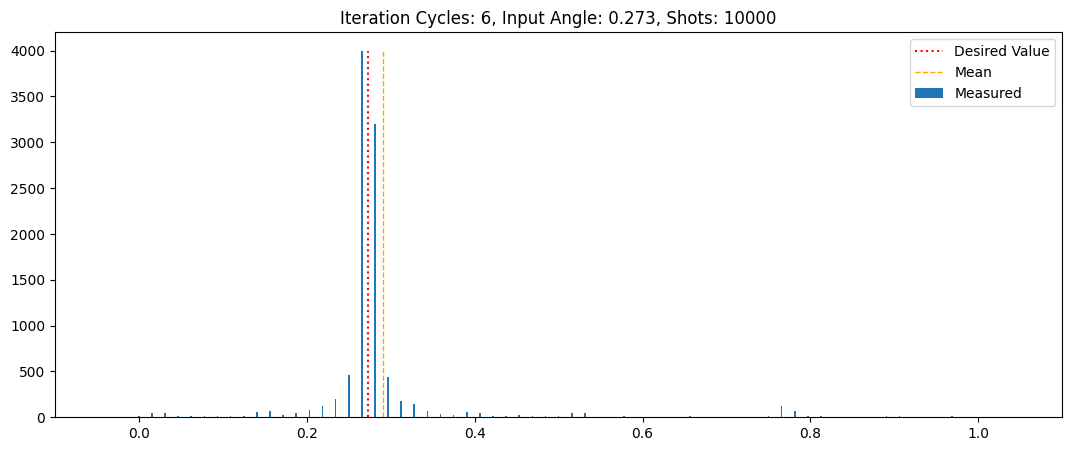

In [93]:
measurement(0.273, 6, 1e4)
#plt.savefig("Figures/ibm_error1.png", dpi = 300)

Difference between Mean of Mesurement and Desired Value:  0.00031249999999999334
Theoretical precision of QPE with the same depth:  0.015625
Improvement by  50.000000000001066


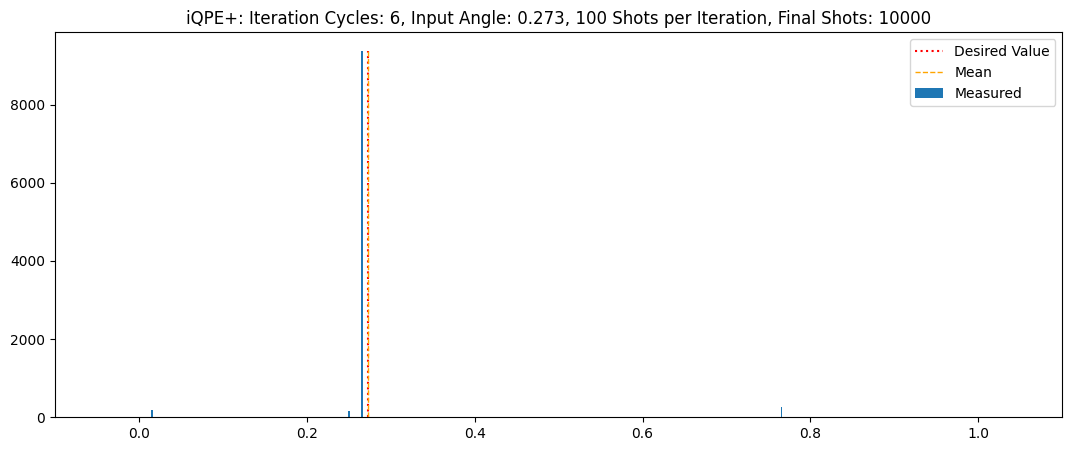

In [94]:
measurement(0.273, 6, 1e4, 100)
#plt.savefig("Figures/ibm_error2.png", dpi = 300)

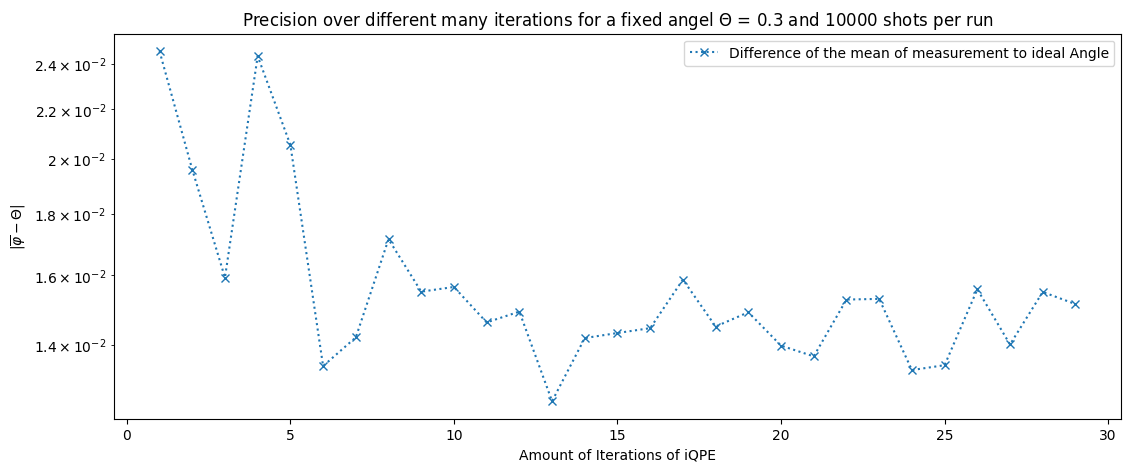

In [95]:
plot_prec_over_its(0.3, 1e4, 30)

plt.savefig("Figures/ibm_error3.png", dpi = 300)

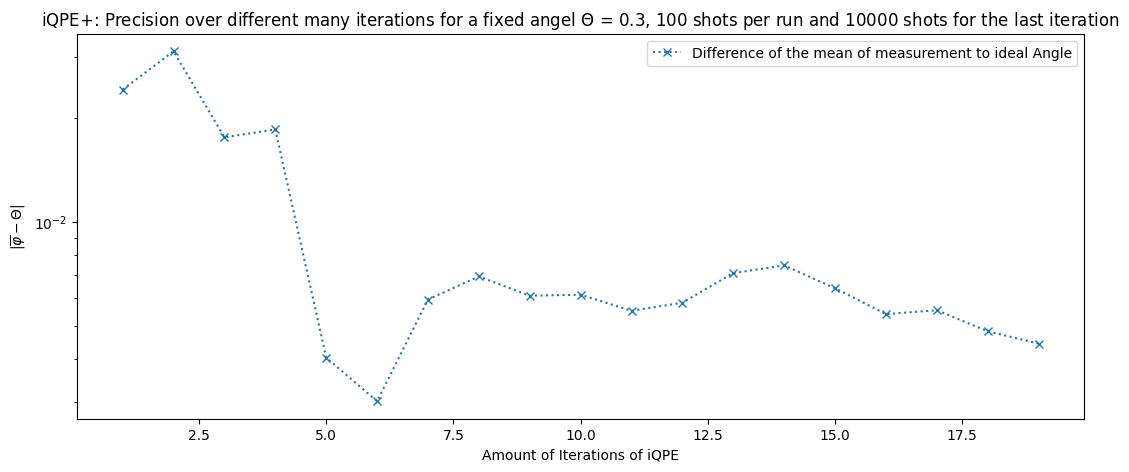

In [96]:
plot_prec_over_its(0.3, 1e4, 20, 100)

plt.savefig("Figures/ibm_error4.png", dpi = 300)

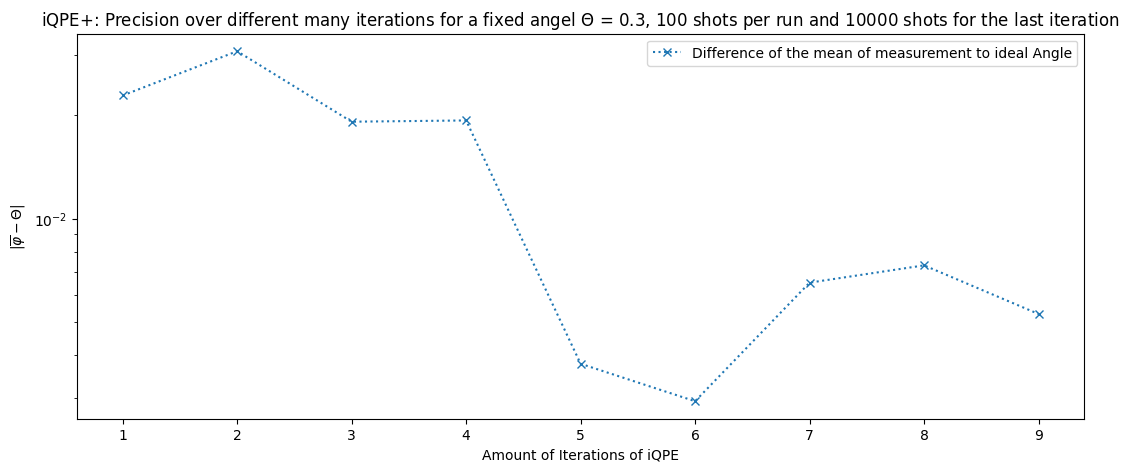

In [97]:
plot_prec_over_its(0.3, 1e4, 10, 100)

plt.savefig("Figures/ibm_error5.png", dpi = 300)

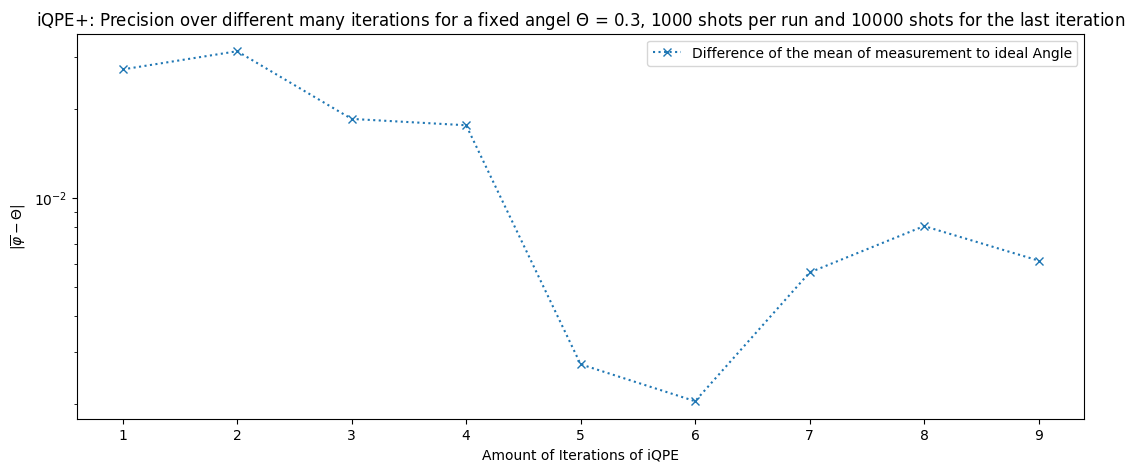

In [98]:
plot_prec_over_its(0.3, 1e4, 10, 1000)

plt.savefig("Figures/ibm_error6.png", dpi = 300)

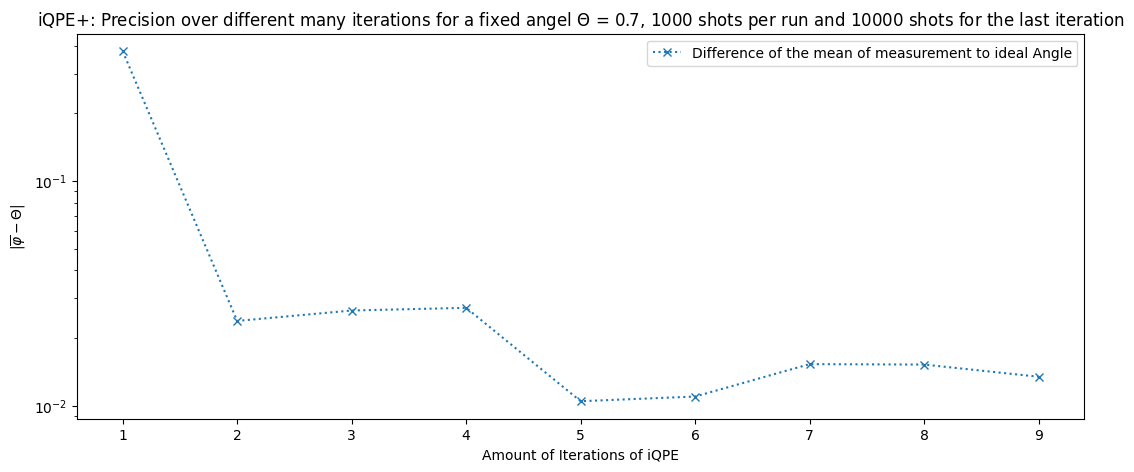

In [102]:
plot_prec_over_its(0.7, 1e4, 10, 1000)

plt.savefig("Figures/ibm_error7.png", dpi = 300)

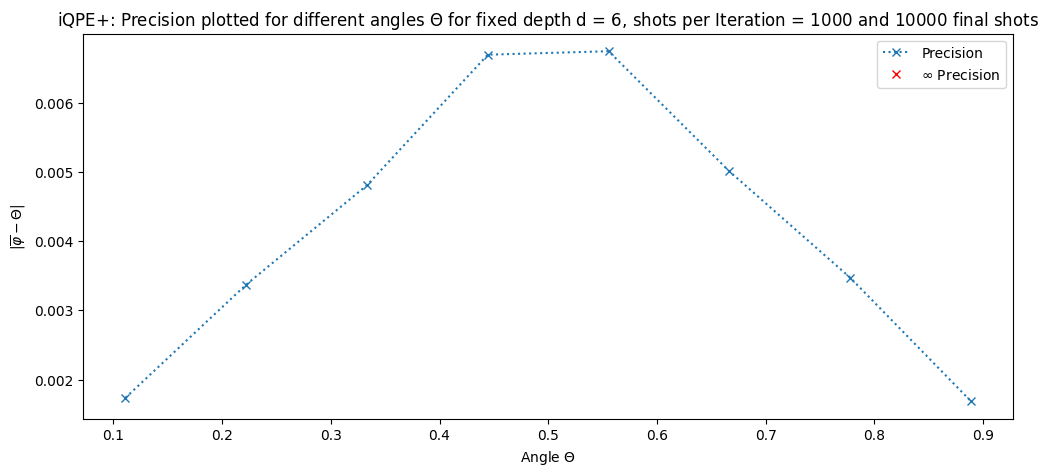

In [104]:
plot_prec_over_angles(1e4, 6, 10, 1000)
plt.savefig("Figures/ibm_error8.png", dpi = 300)